In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

from FinancialMachineLearning.feature_importance.importance import (
    mean_decrease_impurity,
    mean_decrease_accuracy,
    single_feature_importance,
    plot_feature_importance
)
from FinancialMachineLearning.feature_importance.orthogonal import get_orthogonal_features
from FinancialMachineLearning.machine_learning.cross_validation import PurgedKFold, ml_cross_val_score
from FinancialMachineLearning.multiprocess.multiprocess import process_jobs

In [5]:
from sklearn.datasets import make_classification

def get_test_data(
        n_features : int = 40,
        n_informative : int = 10,
        n_redundant : int = 10,
        n_samples : int = 10000,
        random_state : int = 42,
        sigma_std : float = 0.0
) : 
    from sklearn.datasets import make_classification
    
    np.random.seed(random_state)
    
    trnsX, cont = make_classification(
        n_samples = n_samples,
        n_features = n_features,
        n_informative = n_informative,
        n_redundant = n_redundant,
        random_state = random_state,
        shuffle = False
    )
    
    df0_index = pd.date_range(start = pd.to_datetime('today') - pd.to_timedelta(n_samples, unit = 'd'), 
                              periods = n_samples, freq = 'B')

    trnsX, cont = pd.DataFrame(trnsX, index = df0_index), pd.Series(cont, index=df0_index).to_frame('bin')

    df0 = ['I_' + str(i) for i in range(n_informative)] + ['R_' + str(i) for i in range(n_redundant)]
    df0 += ['N_' + str(i) for i in range(n_features - len(df0))]
    
    trnsX.columns = df0
    cont['w'] = 1. / cont.shape[0]
    cont['t1'] = pd.Series(cont.index, index = cont.index)
    
    return trnsX, cont

In [10]:
def feature_importances(X, cont, method, allow_masking_effects=False, n_splits=10):
    max_features = None if allow_masking_effects else 1
    clf = DecisionTreeClassifier(
        criterion='entropy', max_features=max_features, class_weight='balanced', min_weight_fraction_leaf=0.0
    )
    clf = BaggingClassifier(
        estimator=clf, n_estimators=1000, max_features=1.0, max_samples=1.0, oob_score=True, n_jobs=-1
    )
    fit = clf.fit(X, cont['bin'])
    oob_score = fit.oob_score_

    cv_gen = PurgedKFold(n_splits=n_splits, samples_info_sets=cont['t1'])
    oos_score = ml_cross_val_score(clf, X, cont['bin'], cv_gen=cv_gen, scoring=accuracy_score).mean()

    if method == 'MDI':
        imp = mean_decrease_impurity(fit, X.columns)
    elif method == 'MDA':
        imp = mean_decrease_accuracy(clf, X, cont['bin'], cv_gen, scoring=accuracy_score)
    elif method == 'SFI':
        imp = single_feature_importance(clf, X, cont['bin'], cv_gen, scoring=accuracy_score)
    
    return imp, oob_score, oos_score


def test_data_func(X, cont, run='', allow_masking_effects=False, methods=['MDI', 'MDA', 'SFI']):
    for method in methods:
        feature_imp, oob_score, oos_score = feature_importances(X, cont, method, allow_masking_effects)
        plot_feature_importance(
            feature_imp, oob_score=oob_score, oos_score=oos_score,
            save_fig = False
        )


#### generate Test Data Set 

In [11]:
X, cont = get_test_data(n_features=12, n_informative=4, n_redundant=4, n_samples=5000)
X.head()

,I_0,I_1,I_2,I_3,R_0,R_1,R_2,R_3,N_0,N_1,N_2,N_3
2010-04-26 14:37:21.558804,-0.814828,-0.799328,-1.167030,-1.093748,0.250751,0.019002,-1.894898,0.355590,0.181207,0.495571,1.730627,0.662368
2010-04-27 14:37:21.558804,-1.078724,-0.839524,-1.924569,-0.805868,0.621915,0.796044,-2.292527,0.590200,-0.119773,-0.498053,-1.733884,-1.566398
2010-04-28 14:37:21.558804,-1.466586,-1.367013,-1.698378,-0.826454,0.884487,0.530391,-2.481606,0.294035,0.855794,-1.975879,1.011292,0.803394
2010-04-29 14:37:21.558804,-0.455518,0.214157,-0.913041,-2.162253,-0.924746,-0.462172,-1.675132,1.026584,-0.864981,0.181578,0.576195,0.091961
2010-04-30 14:37:21.558804,-1.474218,-2.208105,0.043939,-0.256966,1.211348,-0.688370,-1.490825,-0.929770,1.231224,-1.392096,0.504166,-0.608915


#### PCA transformation

PCA : orthogonal 

In [12]:
Xdot = pd.DataFrame(get_orthogonal_features(X), index = X.index).add_prefix("PCA_")
Xdot.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
2010-04-26 14:37:21.558804,0.444177,-0.926026,0.978648,0.058669,-1.527935,1.110713,0.078998,-0.000227
2010-04-27 14:37:21.558804,1.188982,-0.558245,1.196094,0.352870,1.838267,-1.351381,-0.627890,0.181328
2010-04-28 14:37:21.558804,1.367485,-1.063329,1.006346,-1.015021,0.646933,2.218645,-0.163585,-0.177154
2010-04-29 14:37:21.558804,-0.681819,-0.409955,1.877203,0.695071,-0.358415,0.237452,0.642137,-0.133785
2010-04-30 14:37:21.558804,0.839657,-2.113915,-0.621997,-0.426625,0.867072,1.172069,-1.299989,-0.544356


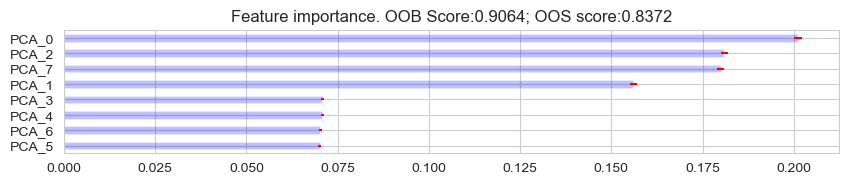

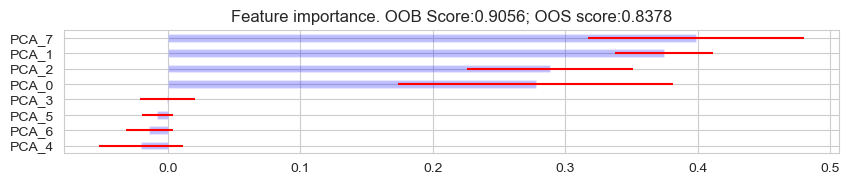

KeyboardInterrupt: 

In [13]:
test_data_func(Xdot, cont)

In [14]:
Xdotdot = pd.concat([X, Xdot], axis=1)

/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in test_times.iteritems():
/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in 

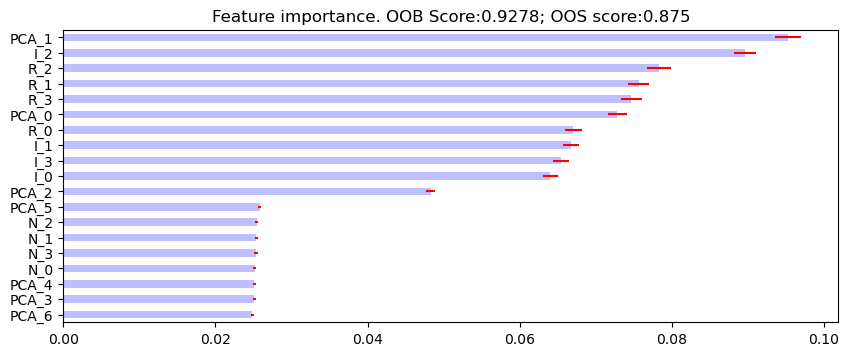

/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in test_times.iteritems():
/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in 

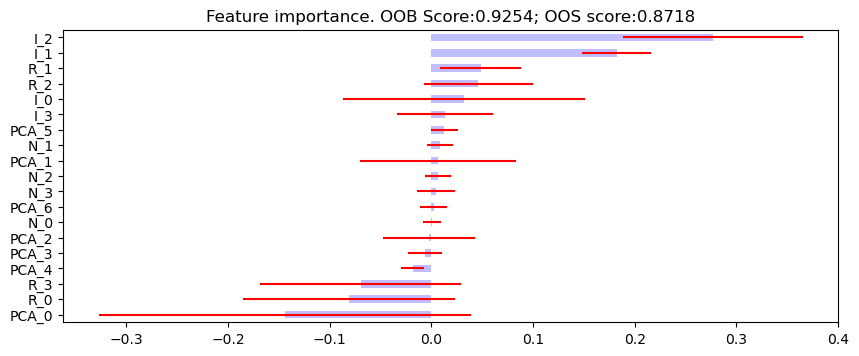

/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in test_times.iteritems():
/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in 

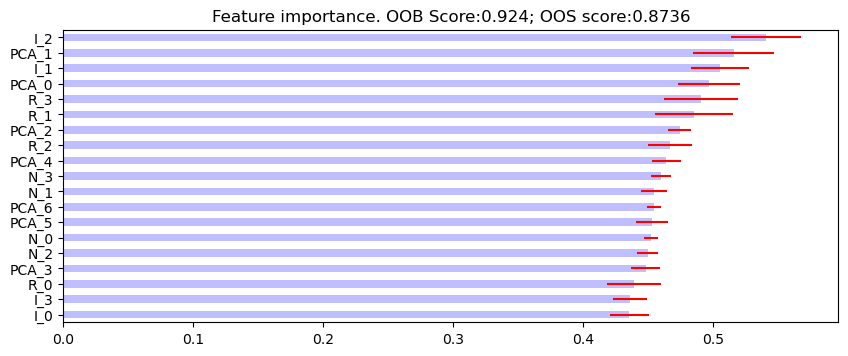

In [15]:
test_data_func(Xdotdot, cont)

In [4]:
import os
os.chdir('..')
os.chdir('..')
os.getcwd()

'/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning'

In [7]:
cont

,bin,w,t1
2023-09-18 10:29:12.002465,0,0.0002,2023-09-18 10:29:12.002465
2023-09-18 10:30:12.002465,0,0.0002,2023-09-18 10:30:12.002465
2023-09-18 10:31:12.002465,0,0.0002,2023-09-18 10:31:12.002465
2023-09-18 10:32:12.002465,0,0.0002,2023-09-18 10:32:12.002465
2023-09-18 10:33:12.002465,0,0.0002,2023-09-18 10:33:12.002465
...,...,...,...
2023-09-21 21:44:12.002465,1,0.0002,2023-09-21 21:44:12.002465
2023-09-21 21:45:12.002465,1,0.0002,2023-09-21 21:45:12.002465
2023-09-21 21:46:12.002465,1,0.0002,2023-09-21 21:46:12.002465
2023-09-21 21:47:12.002465,1,0.0002,2023-09-21 21:47:12.002465


In [8]:
matrix = pd.read_csv('./Data/labeled_vertical10.csv', index_col = 0)
matrix

,price,return,fracdiff,volatility,concurrency,uniqueness,side,label
2010-04-29 10:26:57,58.2801,-0.011465,10.476812,0.010964,20.0,0.074445,-1.0,1
2010-04-29 11:09:15,58.3600,-0.012819,10.507715,0.011247,7.0,0.075186,-1.0,1
2010-04-29 11:34:28,58.4100,-0.013664,10.488812,0.011638,5.0,0.067364,-1.0,1
2010-04-29 11:44:01,58.4900,-0.012306,10.540226,0.011979,6.0,0.066014,-1.0,1
2010-04-29 12:00:06,58.4498,-0.014335,10.465450,0.012262,7.0,0.059366,-1.0,1
...,...,...,...,...,...,...,...,...
2023-05-08 15:16:20,152.1563,-0.010951,26.030479,0.010701,46.0,0.020092,-1.0,1
2023-05-08 15:16:37,152.0900,-0.011112,25.963539,0.010595,47.0,0.022152,-1.0,1
2023-05-08 15:36:39,152.0701,-0.010391,25.952489,0.010387,48.0,0.020022,-1.0,1
2023-05-08 15:47:11,152.1800,-0.011105,26.065165,0.010283,49.0,0.020007,-1.0,1


In [10]:
t1 = pd.read_csv('./Data/t1_vertical.csv', index_col = 0)
t1

,t1,trgt,pt,sl
2009-10-02 09:31:33,2009-10-02 10:35:54,0.010011,1,1
2009-10-02 09:44:59,2009-10-02 10:35:54,0.010268,1,1
2009-10-02 09:53:14,2009-10-05 09:59:08,0.010379,1,1
2009-10-02 10:01:56,2009-10-05 09:59:08,0.010430,1,1
2009-10-02 10:09:13,2009-10-05 09:59:08,0.010453,1,1
...,...,...,...,...
2023-05-08 15:16:20,2023-05-10 13:27:11,0.010701,1,1
2023-05-08 15:16:37,2023-05-12 12:21:00,0.010595,1,1
2023-05-08 15:36:39,2023-05-10 13:27:11,0.010387,1,1
2023-05-08 15:47:11,2023-05-10 13:27:11,0.010283,1,1


In [11]:
t1[-29415:]

,t1,trgt,pt,sl
2010-04-29 10:26:57,2010-04-30 15:47:16,0.010964,1,1
2010-04-29 11:09:15,2010-04-30 15:47:16,0.011247,1,1
2010-04-29 11:34:28,2010-04-30 15:47:16,0.011638,1,1
2010-04-29 11:44:01,2010-04-30 14:55:47,0.011979,1,1
2010-04-29 12:00:06,2010-04-30 15:47:16,0.012262,1,1
...,...,...,...,...
2023-05-08 15:16:20,2023-05-10 13:27:11,0.010701,1,1
2023-05-08 15:16:37,2023-05-12 12:21:00,0.010595,1,1
2023-05-08 15:36:39,2023-05-10 13:27:11,0.010387,1,1
2023-05-08 15:47:11,2023-05-10 13:27:11,0.010283,1,1


In [13]:
cont = pd.concat([matrix['label'], t1[-29415:]['trgt'], t1[-29415:]['t1']], axis = 1)
cont.columns = ['bin','w','t1']
cont

,bin,w,t1
2010-04-29 10:26:57,1,0.010964,2010-04-30 15:47:16
2010-04-29 11:09:15,1,0.011247,2010-04-30 15:47:16
2010-04-29 11:34:28,1,0.011638,2010-04-30 15:47:16
2010-04-29 11:44:01,1,0.011979,2010-04-30 14:55:47
2010-04-29 12:00:06,1,0.012262,2010-04-30 15:47:16
...,...,...,...
2023-05-08 15:16:20,1,0.010701,2023-05-10 13:27:11
2023-05-08 15:16:37,1,0.010595,2023-05-12 12:21:00
2023-05-08 15:36:39,1,0.010387,2023-05-10 13:27:11
2023-05-08 15:47:11,1,0.010283,2023-05-10 13:27:11


In [14]:
X_mat = matrix.iloc[:, [0,2,3,4,5]]

/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in test_times.iteritems():
/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in 

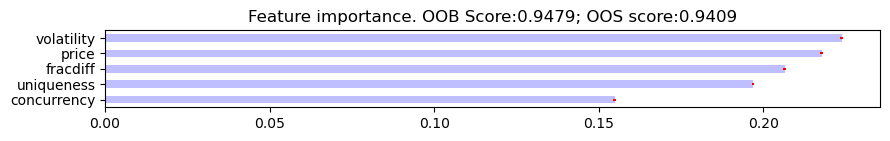

/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in test_times.iteritems():
/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in 

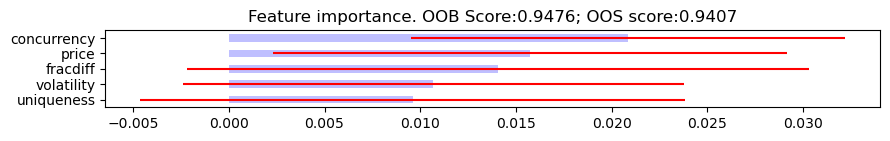

/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in test_times.iteritems():
/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in 

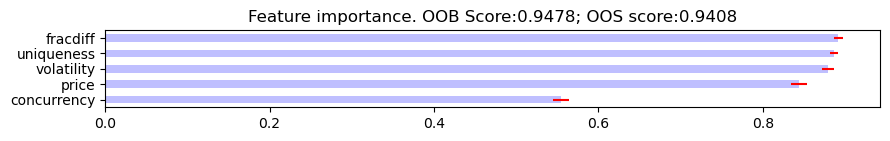

In [15]:
test_data_func(X_mat, cont)